<span style="color:####; font-family: sabon; font-size: 2em;">
    <center> Anomaly Detection in Fingerprints using Convolutional NN </center> <br>
</span>

<span style="color:####; font-family: sabon; font-size: 1.6em;">
   <center> Machine Learning </center> <br>
    <center> Kevin Emmanuel Soto Hernandez </center> <br>
</span>

In [61]:
#Librerias para le Red Neuronal
import numpy as np
from keras import models
from keras import layers
from keras.utils import to_categorical

#Filtracion de archivos
import re
import os

#Graficacción 
from matplotlib.image import imread
import matplotlib.pyplot as plt

#Metricas de validación
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef
from sklearn.metrics import recall_score, precision_score

In [2]:
def visualizar_imagen(matrix):
    '''
    Para visualizar en imagen el expectro de calor de una matriz
    
    Parámetros
    -----------
    matrix   :  2-D numpy array 
    
    Regresa
    -----------
    Imprime imagen de la matriz
    '''
    fig = plt.figure(figsize=(2.5,2.5))
    ax = fig.add_subplot(111)
    ax.imshow(matrix, origin="upper", cmap=plt.cm.binary_r )
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)

In [3]:
def plot_function(x, y, title, labels):
    plt.ylim((0,1))
    plt.xlabel("Número de época")
    plt.ylabel(title)
    plt.grid(True)
    plt.title("Proceso de entrenamiento de la red neuronal")
    plt.plot(x, color= 'blue')
    plt.plot(y, color= 'purple')
    plt.legend(labels)
    plt.show()

In [4]:
def get_Coor(path):
    """
    Obtiene la lista de las coordenadas 
    de la minutas ubicadas en cada imagen
    
    Parámetros
    ------------
    path: directorio donde se encuentran los archivos de las minutas
    """
    os.chdir(path)
    minutias = os.listdir()
    Coor = []
    for minutia in minutias:
        with open(minutia, 'r') as f:
            lines = f.readlines()
            lines = lines[4:]
            coor = []
            for i in range(len(lines)):
                coor.append([int(i) for i in re.findall(r"[0-9]+", lines[i])[1:3] ])
        Coor.append(coor)
    return Coor

In [5]:
def get_minutia(name_image, Coor, d, n):
    """
    Obtiene el parche de tamaño nxn de una minuta en una imagen aleatoria de
    un fingerprint a través de la perturbacion de las coordenadas de la minuta.
    
    Parámetros
    -----------
    name_image : nombre de la imagen fingerprint
    Coor : lista devuelta por get_Coor()
    d,n : dimensiones de la imagen y del parche respectivamente
    
    """
    while True:
        perturb = np.random.randint(0, n//3, size=2)
        coor = Coor[np.random.randint(0, len(Coor))]
        indexes = (coor[0]-perturb[0], coor[1]-perturb[1])
        
        if 0<= indexes[0] and indexes[0] <= d-n and 0<= indexes[1] and indexes[1] <= d-n:
            break
    
    fingerprint = imread(name_image)
    patch = fingerprint[indexes[0]:indexes[0]+n, indexes[1]:indexes[1]+n]
    return patch

In [6]:
def is_minutia(indexes, Coor, n):
    for x, y in Coor:
        if indexes[0]<=x and x<=indexes[0]+n and indexes[1]<=y and y<=indexes[1]+n:            
            return True
    return False

In [7]:
def get_notminutia(name_image, Coor, d, n):
    """
    Obtiene el parche de tamaño nxn que no contiene una minuta en una imagen aleatoria de
    un fingerprint a través de la perturbacion de las coordenadas de la minuta.
    
    Parámetros
    -----------
    name_image : nombre de la imagen fingerprint
    Coor : lista devuelta por get_Coor()
    d,n : dimensiones de la imagen y del parche respectivamente
    
    """
    indexes = np.random.randint(0, d-n, size=2)
    while is_minutia(indexes, Coor, n): 
        indexes = np.random.randint(0, d-n, size=2)
        
    fingerprint = imread(name_image)
    return fingerprint[indexes[0]:indexes[0]+n, indexes[1]:indexes[1]+n]

In [8]:
def sample_data(path, Coor, samples, d, n, only_minutias):
    os.chdir(path) #directorio de la imagenes
    name_images = os.listdir() #lista de nombres de imagenes
    random_images = np.random.choice(len(name_images), samples, replace=True)
    print("Conjunto de parches generados: ", 2*samples)
        
    #solo para la inicializacion del tensor
    Data = np.empty((0,n,n)) 
    
    if only_minutias:
        for i in random_images:
            patch = get_minutia(name_images[i], Coor[i], d, n)
            Data = np.concatenate((Data, patch[None]),axis=0)
            patch = get_notminutia(name_images[i], Coor[i], d, n)
            Data = np.concatenate((Data, patch[None]),axis=0)
    #else:
     #   for i in random_images:
     #       patch = get_notminutia(name_images[i], Coor[i], d, n)
     #       Data = np.concatenate((Data, patch[None]),axis=0)
    return Data

In [76]:
def metrics(images, real_labels, network):
    predicted = network.predict(images)
    pred_labels = np.empty(2*samples)
    for i in range(predicted2.shape[0]):
        pred_labels[i] = 1 if predicted[i][0] < predicted[i][1] else 0

    CM = confusion_matrix(real_labels, pred_labels)
    errors = 2*samples - np.trace(CM)
    print("Matriz de confución\n",CM,"\nTotal de errores:", errors)
    print('Accuracy:', 1-errors/(2*samples))
    print("F1 Score:", f1_score(real_labels, pred_labels))
    print("Matthews Coef:", matthews_corrcoef(real_labels, pred_labels))
    print("Precision:", precision_score(real_labels, pred_labels))
    print("Recall:", recall_score(real_labels, pred_labels))
    print("Specifity:", CM[0,0]/(CM[0,0]+CM[0,1]))

In [9]:
#path principal
path = os.getcwd()

### Introducción
Las redes neuronales convolucionales, también conocidas como _convnets_, son un tipo de modelo de deep learning que se usa casi universalmente en aplicaciones de visión artificial. Las convnets pueden ser usados en los problemas de clasificación de imágenes (como lo será el caso de este pequeño reporte), en particular aquellos que involucran pequeños conjuntos de datos de imagenes, que son el caso de uso más común si no es una gran empresa de tecnología.
En este reporte aplicaremos una _covnet_ para el problema de clasificación de una base de datos de minutas obtenidas de imágenes de huellas digitales como en la tarea pasada.

### Desarrollo

#### Generación de la base de datos
Primero generamos la base de datos dividiendo las imágenes analizadas con ``MINDTCT`` de la siguiente manera: leemos una imagen de forma aleatoria y seleccionamos un par de coordenadas $(x, y)$ para generar un parche de  $n x n$ desde las coordenadas dadas (digamos de dimensión $28 x 28$ o $32 x 32$ pixeles) y etiquetando cada parche como:

* Clase 1: si contienen al menos una minucia detectada con `MINDTCT`
* Clase 0: si no la contiene ninguna minucia detectada con `MINDTCT`

Así hasta tener nuestro conjunto de datos completo y balaceado (i.e. que existan misma cantidad de datos con clase 1 que con clase 0). Hacemos lo mismo para la base de prueba.

In [10]:
n = 20 #dimensión de los parches (nxn)
d = 300 #dimension de las imagenes (dxd)
samples = 5000

In [11]:
train_Coor = get_Coor(path+"/train_min3")
test_Coor = get_Coor(path+"/test_min3")

In [12]:
#Conjunto de entrenamiento
#images1 = sample_data(path+ "/train_DB3", train_Coor, samples, d, n, only_minutias=True)
#images0 = sample_data(path+ "/train_DB3", train_Coor, samples, d, n, only_minutias=False)
#train_images = np.r_[images0, images1]
train_images = sample_data(path+ "/train_DB3", train_Coor, samples, d, n, only_minutias=True)
visualizar_imagen(train_images[0])
train_images = train_images.reshape(2*samples,n,n,1)/255.0

train_labels_ = np.ones(2*samples)
train_labels_[1::2] = 0
train_labels = to_categorical(train_labels_)

Conjunto de parches generados:  10000
[1. 0. 1. ... 0. 1. 0.]


Conjunto de parches generados:  10000


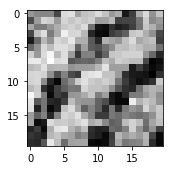

In [34]:
#Conjunto de prueba
#images1 = sample_data(path+ "/test_DB3", test_Coor, samples=samples, d=d, n=n, only_minutias=True)
#images0 = sample_data(path+ "/test_DB3", test_Coor, samples=samples, d=d, n=n, only_minutias=False)
#test_images = np.r_[images0, images1]
test_images = sample_data(path+ "/test_DB3", test_Coor, samples=samples, d=d, n=n, only_minutias=True)
visualizar_imagen(test_images[0])
test_images = test_images.reshape(2*samples,n,n,1)/255.0

test_labels_ = np.ones(2*samples)
test_labels_[1::2] = 0
test_labels = to_categorical(test_labels_)

In [36]:
print(train_images.shape)
print(test_images.shape)

(10000, 20, 20, 1)
(10000, 20, 20, 1)


#### Red Neuronal Convolucional
La diferencia fundamental entre una capa densamente conectada y una capa de convolución es la siguiente: las capas densas aprenden patrones globales en su espacio de características de entrada (por ejemplo, para un dígito MNIST, patrones que involucran todos los píxeles), mientras que las capas de convolución aprenden patrones locales (ver figura 1): en el caso de imágenes, patrones encontrados en pequeñas ventanas 2D de las entradas. En el ejemplo debajo, estas ventanas son todas de 3 × 3.

![mnist](mnist.PNG)


Las _covnets_ tienen dos propiedades fundamentales:

* Los patrones que aprenden son invariantes antes la traslación. Es decir, necesitan menos ejemplos de entrenamiento para aprender representaciones y que tienen poder de generalización.

* Pueden aprender jerarquías espaciales de patrones (ver figura 2). Una primera capa de convolución aprenderá pequeños patrones locales, como los bordes, una segunda capa de convolución aprenderá patrones más grandes hechos de las características de las primeras capas, y así sucesivamente.

![cat](cat.png)

Aquí, nuestra red consiste en una secuencia de tres capas convolucionaes con 128, 64 y 64 filtros respectivante. El tamaño del kernel será de tamaño $3x3$ en los tres casos con la idea de que las redes encuentren patrones de minutas en la imagenes a clasificar. Dentro de cada capa convolucional se aplicará un max-pooling que "recortará" las imagenes obtenidas a la mitad, esto con la idea de que minumice la cantidad de parámetros en la arquitectura completa. Al final, vectorizamos cada imagen convolucionada y la metemos en una capa de neuronas densamente conectadas (también llamadas totalmente conectadas) con la función de activación "softmax" que es clásica en los algoritmos de clasificación de 2 salidas (clase 1 y clase 0), lo que significa que devolverá una matriz de 2 puntuaciones de probabilidad (que se suman 1). Cada puntaje será la probabilidad de que la imagen del dígito actual pertenezca a una de nuestras clases $y_i \in \{ 0, 1 \}$ (minuta o no minuta).

In [421]:
network1 = models.Sequential()

network1.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(n, n, 1)))
network1.add(layers.MaxPooling2D((2, 2)))

network1.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
network1.add(layers.MaxPooling2D((2, 2)))

network1.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
#network.add(layers.MaxPooling2D((2, 2)))

network1.add(layers.Flatten())
network1.add(layers.Dense(2, activation='softmax'))

network1.compile(optimizer='adadelta',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

network1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_346 (Conv2D)          (None, 18, 18, 128)       1280      
_________________________________________________________________
max_pooling2d_254 (MaxPoolin (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_347 (Conv2D)          (None, 7, 7, 64)          73792     
_________________________________________________________________
max_pooling2d_255 (MaxPoolin (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_348 (Conv2D)          (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_89 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_124 (Dense)            (None, 2)                 130       
Total para

Para preparar la red para la capacitación, debemos elegir tres cosas más, como parte del paso de compilación:

* **loss:** Una función de pérdida en la cual la red podrá medir su rendimiento en los datos de entrenamiento y, por lo tanto, cómo podrá dirigirse en la dirección correcta.

* **optimizer:** Un optimizador cuyo mecanismo tomará la red para actualizar la estructura, basándose en los datos que ve y su función de pérdida.

* **metrics:** Métricas para monitorear durante el entrenamiento y las pruebas. Aquí, solo nos importará la precisión (la fracción de las imágenes que se clasificaron correctamente).

Antes de entrenar, preprocesaremos los datos cambiándolos a la forma que la red espera y escalando de modo que todos los valores estén en el intervalo [0,1] dividiendo entre el valor del maximo elemento (255). También necesitamos codificar categóricamente las etiquetas con la funcion de Keras ``to_categorical()``. La base de datos es separada en dos partes (8,000 datos), los datos de entrenamiento y los datos de validación (24,000 datos).

Ahora estamos listos para entrenar a la red, lo que en Keras se realiza mediante una llamada al método ``fit`` de la red. Aquí, la red utiliza los 8,000 datos en paquetes de 100 (``batch_size``) y se actualiza en 5 epocas. 

In [450]:
model1 = network1.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=100,
                    shuffle=True,
                    validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
9000/9000 [==============================] - 2s 177us/step - loss: 0.6400 - acc: 0.6222 - val_loss: 0.7360 - val_acc: 0.5490
Epoch 2/20
9000/9000 [==============================] - 1s 144us/step - loss: 0.6392 - acc: 0.6188 - val_loss: 0.6333 - val_acc: 0.7800
Epoch 3/20
9000/9000 [==============================] - 1s 146us/step - loss: 0.6376 - acc: 0.6189 - val_loss: 0.8145 - val_acc: 0.4320
Epoch 4/20
9000/9000 [==============================] - 1s 145us/step - loss: 0.6367 - acc: 0.6244 - val_loss: 0.6592 - val_acc: 0.7670
Epoch 5/20
9000/9000 [==============================] - 1s 146us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.7692 - val_acc: 0.5410
Epoch 6/20
9000/9000 [==============================] - 1s 145us/step - loss: 0.6355 - acc: 0.6284 - val_loss: 0.7688 - val_acc: 0.6130
Epoch 7/20
9000/9000 [==============================] - 1s 145us/step - loss: 0.6346 - acc: 0.6317 - val_loss: 0.6997 - val_acc: 0.6580


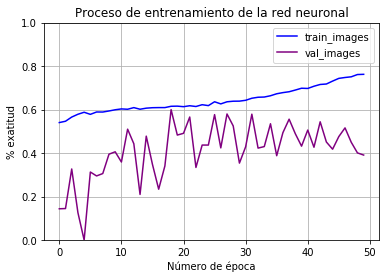

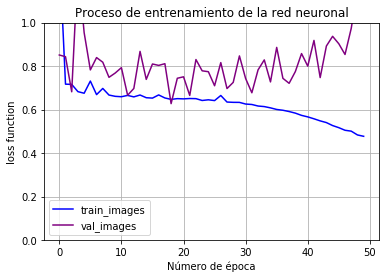

In [355]:
plot_function(model1.history['acc'], model1.history['val_acc'], '% exatitud', ['train_images', 'val_images'])
plot_function(model1.history['loss'], model1.history['val_loss'], 'loss function', ['train_images', 'val_images'])

Probamos la exactitud de la red con los datos de prueba.

In [74]:
metrics(test_images, test_labels_, network1)

Matriz de confución
 [[2360 2640]
 [1948 3052]] 
Total de errores: 4588
Accuracy: 0.5412
F1 Score: 0.5708941264496821
Matthews Coef: 0.08320068904540917
Precision: 0.5361911454673226
Recall: 0.6104
Specifity: 0.472


Observamos que la red entra en una fase de overfitting alrededor de la epoca 25, por lo que podemos mejorar el proceso de aprendizaje agregando una función "dropout" para evitar el overfitting temprano. _Dropout_ es una técnica en la que las neuronas seleccionadas al azar se ignoran durante el entrenamiento. Estas son "desactivadas" al azar, en nuestro caso desactivaremos un 30% de la neuronas. Esto significa que su contribución a la activación de las neuronas posteriores se elimina temporalmente en el pase hacia adelante y las actualizaciones de peso no se aplican a la neurona en el pase hacia atrás. Usando la misma arquitectura anterior y los mismos parámetros de inicialización nos queda:

In [26]:
network2 = models.Sequential()

network2.add(layers.Conv2D(256, kernel_size=(3,3), activation='relu', input_shape=(n, n, 1)))
#network2.add(layers.Dropout(0.3))
network2.add(layers.MaxPooling2D((2, 2)))
network2.add(layers.BatchNormalization())

network2.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
network2.add(layers.Dropout(0.5))
network2.add(layers.MaxPooling2D((2, 2)))
#network2.add(layers.BatchNormalization())

network2.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
#network2.add(layers.MaxPooling2D((2, 2)))
#network2.add(layers.BatchNormalization())

network2.add(layers.Flatten())
network2.add(layers.Dropout(0.3))
network2.add(layers.Dense(2, activation='softmax'))

network2.compile(optimizer='adadelta',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

network2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 18, 18, 256)       2560      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 9, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 9, 256)         1024      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 128)         295040    
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 1, 64)          73792     
__________

In [27]:
network2.compile(optimizer='adadelta',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model2 = network2.fit(train_images,
                    train_labels,
                    epochs=30,
                    batch_size=50,
                    shuffle=True,
                    validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 3s 343us/step - loss: 0.6899 - acc: 0.5841 - val_loss: 0.6894 - val_acc: 0.5380
Epoch 2/30
9000/9000 [==============================] - 2s 254us/step - loss: 0.6683 - acc: 0.6037 - val_loss: 0.6850 - val_acc: 0.5850
Epoch 3/30
9000/9000 [==============================] - 2s 250us/step - loss: 0.6670 - acc: 0.6073 - val_loss: 0.6705 - val_acc: 0.6090
Epoch 4/30
9000/9000 [==============================] - 2s 249us/step - loss: 0.6610 - acc: 0.6123 - val_loss: 0.6708 - val_acc: 0.6050
Epoch 5/30
9000/9000 [==============================] - 2s 253us/step - loss: 0.6573 - acc: 0.6194 - val_loss: 0.6659 - val_acc: 0.6060
Epoch 6/30
9000/9000 [==============================] - 2s 252us/step - loss: 0.6538 - acc: 0.6202 - val_loss: 0.6551 - val_acc: 0.6160- loss: 0
Epoch 7/30
9000/9000 [==============================] - 2s 255us/step - loss: 0.6476 - acc: 0.6340 - val_loss: 0.6685 - val_acc

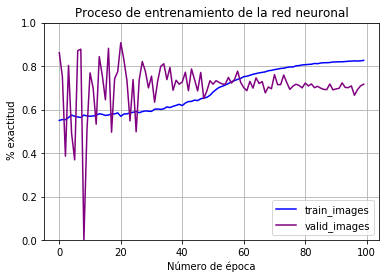

In [98]:
plot_function(model2.history['acc'], model2.history['val_acc'], '% exatitud', ['train_images', 'val_images'])

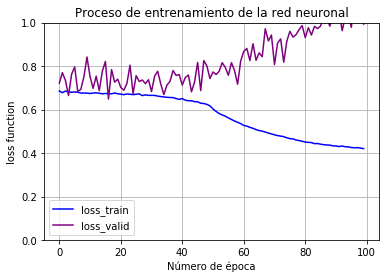

In [99]:
plot_function(model2.history['loss'], model2.history['val_loss'], 'loss function', ['train_images', 'val_images'])

In [77]:
metrics(test_images, test_labels_, network2)

Matriz de confución
 [[3658 1342]
 [ 580 4420]] 
Total de errores: 1922
Accuracy: 0.8078
F1 Score: 0.821408660100353
Matthews Coef: 0.622875877969736
Precision: 0.767094758764318
Recall: 0.884
Specifity: 0.7316


#### Conclusiones
La exactitud en la predicción de las clases del conjunto de datos de validación resultó ser del 54.41% y del 80.78% para la red convolucional y la red con regularizacipon respectivamente. Esta brecha entre la exactitud del entrenamiento y la predicción en los datos de prueba es un ejemplo de un equilibrio entre ambas metricas, por lo que podemos decir que nuetro modelo carece de overfitting en al menos un numéro dado de epocas para la red, dejenos explicar esto último de manera expedita. Observe las graficas del proceso de entrenamiento para ambas redes neuronales, la primera impresión es que en la red sin regularización alcanza el overfitting alrededor de la epoca 20, mientras que la red con regularización la alcanza alrededor de la epoca 50. Esto indica que nuestro modelo de entrenamiento al solo seleccionar parte de las neuronas está cobrando el efecto esperado y al final los apuntes en las metricas de validación lo reafirman.

Otra observación remarcable es la alta dependencia de la red neuronal convolucional a los parámetros de entrada (número de epocas, batch_size, total de datos, etc.) que fue la parte más dificil de este pequeño reporte: encontrar los parámetros ideales. En ciertas ocaciones, de hecho, nuestro modelo alcanzaba un ``accuracy`` de 0.0% aunque las clases de la etiquetas estuvieran valanzeadas; un fénomeno que hasta la fecha no logramos explicar. Tambien está el problema de la minutas, resulta que la aplicación del programa de la NBIST cuenta con falsos positivos y al seleccionarlos arruina la precisión de nuetra red neuronal, pero no podemos hacer nada más en este aspecto (no sabemos aún como). Por esto, creemos que nuestros resultados son satisfactorios (más de lo esperado). Para explicar este extraño fenomeno, habría que investigar de una manera más detallada, como funcionan estas redes neuronales implementadas en Keras.